# Vulcan Analytics Presentation - DataHacks 2021
## Predicting the S&P 500 using various economic indexes
##### Arunav Gupta, Brian Huang, Kyle Nero

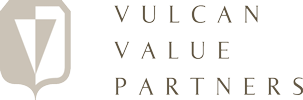

In [33]:
import plotly as plot
import numpy as np
import pandas as pd
from prophet import Prophet

# Abstract
<p>
    For years, financial analysts, data scientists, and every day investors have attempted to predict the future of the S&P 500 index. There are countless features that can potentially affect the value of the index, such as the economic performance of different US sectors as well as the status of foreign markets.

Over the past 36 hours, we have been building and tuning a model that uses a variety of other economic indices in the United States as features to predict the value of the S&P. We were given observations from a total 68 other indices and found the optimal combination of features to maximize interpretability and minimize error. We built our model using Prophet, an open source library developed by Facebook in 2018 which enables highly accurate time series predictions.

We found that the most important factors were the Transportation and Warehousing Industries, the Services Sector, and Nonindustrial Supply Production. Some of the least important factors were the Bank Funding Rate, the Business Application Volume, and the Unemployment Rate. The unemployment rate was a bit surprising, but our guess is that the Unemployment Rate was insignificant because there is a relatively low correlation between individuals who lost their jobs during the COVID-19 pandemic and individuals that invest in the S&P. We also included the Infectious Disease Index in our model because it was important for predicting the S&P after March 2020, at the start of the pandemic.
    </p>

# Data Cleaning and Pre-Processing

- **Pivoting**: In order to format the data into a more usable manner, we pivotted the table to set the time series as columns and the observations as row values. This allowed us to visualize and access individual time series entries more effectively

![Alt](pivot.png "Pivot")



In [34]:
messy_obs = pd.read_csv("data/observations_train.csv")
# read the csv file

messy_obs["date"] = pd.to_datetime(messy_obs["date"])
# convert to date time

- **Normalization**: The sixty-eight time series entries were given in a variety of units (Percentages, Exchange Rates, Unemployment Rates, Billions of Dollars), which meant normalization was neccesary to most effectively compare the different entries. 

In [35]:
obs_pivot = messy_obs.pivot(values="value", index="date", columns="series_id")
# pivot the table

normalize = lambda col: (col - col.mean()) / col.std()
normed_obs = obs_pivot.apply(normalize, axis=0)
# normalize data

- **Dealing with Null Values**: While working with the data, there were an abundance of null values that had to be dealt with. In order to deal with these values, we back-filled all the data first and then forward filled the rest of the null values. We back filled generally due to the fact that most data in our set is collected at the end of the time period and reflects the previous time period, not the next time period. Forward filling dealt with what little discrepancies were left.

In [36]:
normed_obs.head()

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,PCUOMINOMIN,SFTPAGRM158SFRBSF,SP500,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.066997
2000-01-03,-1.034676,NaN,-1.290420,NaN,NaN,NaN,NaN,NaN,1.218044,-1.153070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.101209
2000-01-04,-0.965665,NaN,-1.251178,NaN,NaN,NaN,NaN,NaN,1.218162,-1.064590,...,NaN,NaN,NaN,NaN,0.783933,NaN,NaN,NaN,NaN,1.874472
2000-01-05,-1.057680,NaN,-1.316581,NaN,NaN,NaN,NaN,NaN,1.218044,-1.049651,...,NaN,NaN,NaN,NaN,0.736376,-1.5885,-1.577472,NaN,NaN,-0.383635
2000-01-06,-1.080684,NaN,-1.316581,NaN,NaN,NaN,NaN,NaN,1.217926,-1.055971,...,NaN,NaN,NaN,NaN,0.807712,NaN,NaN,NaN,NaN,-0.409119


In [37]:
normed_obs.fillna(method='bfill', inplace = True)
normed_obs.fillna(method='ffill', inplace = True)

- **Filtering out data**: We found that the S&P500 data did not start until 02-14-2011, so filtering out all the data that came before that date aided in getting rid of unneccesary noise. 

In [38]:
observations = normed_obs[normed_obs.index >= '02-14-2011']
# filter out any dates that are before designated date
observations.head()

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,PCUOMINOMIN,SFTPAGRM158SFRBSF,SP500,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD
date,,,,,,,,,,,,,,,,,,,,,
2011-02-14,-0.068511,1.424496,-0.191647,0.614001,0.263285,-0.14148,0.058255,-0.590029,-0.772034,0.753857,...,1.047525,-0.088386,-1.283833,0.475112,-0.619011,0.263166,0.235511,0.016147,1.637112,-0.360459
2011-02-15,0.069513,1.424496,-0.191647,0.614001,0.263285,-0.14148,0.058255,-0.590029,-0.781610,0.765348,...,1.047525,-0.088386,-1.294698,0.475112,-0.619011,0.263166,0.235511,0.016147,1.637112,-0.433198
2011-02-16,0.069513,1.424496,-0.191647,0.614001,0.263285,-0.14148,0.058255,-0.590029,-0.781610,0.795799,...,1.047525,-0.088386,-1.273750,0.401980,-0.595232,0.263166,0.235511,0.016147,1.637112,-0.206956
2011-02-17,0.138524,1.424496,-0.152405,0.614001,0.263285,-0.14148,0.058255,-0.590029,-0.785630,0.833145,...,1.047525,-0.088386,-1.263390,0.450735,-0.523896,0.295239,0.268779,0.016147,1.637112,-0.516571
2011-02-18,0.184532,1.424496,-0.126244,0.614001,0.263285,-0.14148,0.058255,-0.590029,-0.799699,0.868193,...,1.047525,-0.088386,-1.256886,0.621376,-0.547675,0.295239,0.268779,0.016147,1.637112,-0.540650


# Prophet
![Alt](prophet.png "Prophet")

# What is Prophet?
- Developed by Facebook in 2018 for internal business applications use- 
- Considered state-of-the-art for at-scale processing
- Generalized Additive Model (GAM):




















$$y(t) = g(t) +  s(t) + h(t) + \epsilon_t$$

Where $g(t)$ is a trend function (non-periodic changes), $s(t)$ models seasonal changes, and $h(t)$ measures the effect of holidays (we don’t use this). We assume $\epsilon_t \sim \mathcal{N}(0, 1)$.








# Model
**Pros:**
   - Drop-in, ease of use, automatic
   - Multiple regressors
   - Better for non-stationary data without having to adjust for stationarity
   - Fast, many models can be tested at once
   - Automatic changepoint detection (useful to find changes in market sentiment, like around a pandemic) 
   <br>

**Cons:**
   - Slower cross-validation
   - Somewhat of a black box - more on this later

# Trained using gradient descent, but it’s fast!

## How do we use it:

3 models: 1 week, 1 month, 1 year
Each one is fit on a set of regressors, which are columns from the cleaned observations table from earlier
To add regressors:


``` Python
model = Prophet(**params)
model.add_regressor(“<NAME OF COLUMN>”)
```

Tells Prophet to include the feature when training

# Feature Selection & Training:

``` Python
def columnCleaner(path, columns, date="2011-02-14", normalize_sp5=True):

    """
    This function cleans and returns a dataframe that can be fit to our Prophet model.
    path: the file path/csv path that we want to read
    columns: the columns that we want to fit
    date: the date range we want for the SP500
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    messy_obs = pd.read_csv(path)
    # read the csv file

    messy_obs["date"] = pd.to_datetime(messy_obs["date"])
    # convert to date time

    obs_pivot = messy_obs.pivot(values="value", index="date", columns="series_id")
    # pivot the table
    temp = obs_pivot[obs_pivot.index >= date]

    mu = temp["SP500"].mean()
    s = temp["SP500"].std()

    normalize = lambda col: (col - col.mean()) / col.std()
    normed_obs = obs_pivot.apply(normalize, axis=0)
    # normalize data

    observations = obs_pivot = normed_obs[normed_obs.index >= date]
    # filter out any dates that are before designated date

    if normalize_sp5:
        df = pd.DataFrame({"ds": observations.index, "y": observations["SP500"]})
    else:
        df = pd.DataFrame({"ds": observations.index, "y": temp["SP500"]})
    df.set_index("ds", inplace=True)
    # create the dataframe we return

    # code above organizes table into usable format

    for col in columns:
        try:
            fit = pd.DataFrame(
                {"ds": observations.index, str(col): observations[str(col)]}
            )
        except:
            print(f"Dropping Column: {col}")
            continue
        # create our table for the column entry in our columns list
        fit.fillna(method="bfill", inplace=True)
        fit.fillna(method="ffill", inplace=True)
        # filter out any null values

        fit_column = fit[str(col)]
        # gets a series for our respective column

        df[str(col)] = fit_column
        # adds that column to our dataframe

    df.reset_index(inplace=True)

    return df, mu, s

features = columnCleaner("data/observations_train.csv", columns=cols, normalize_sp5=False)
m.fit(features)
```


# Model optimization

#### Number of Factors

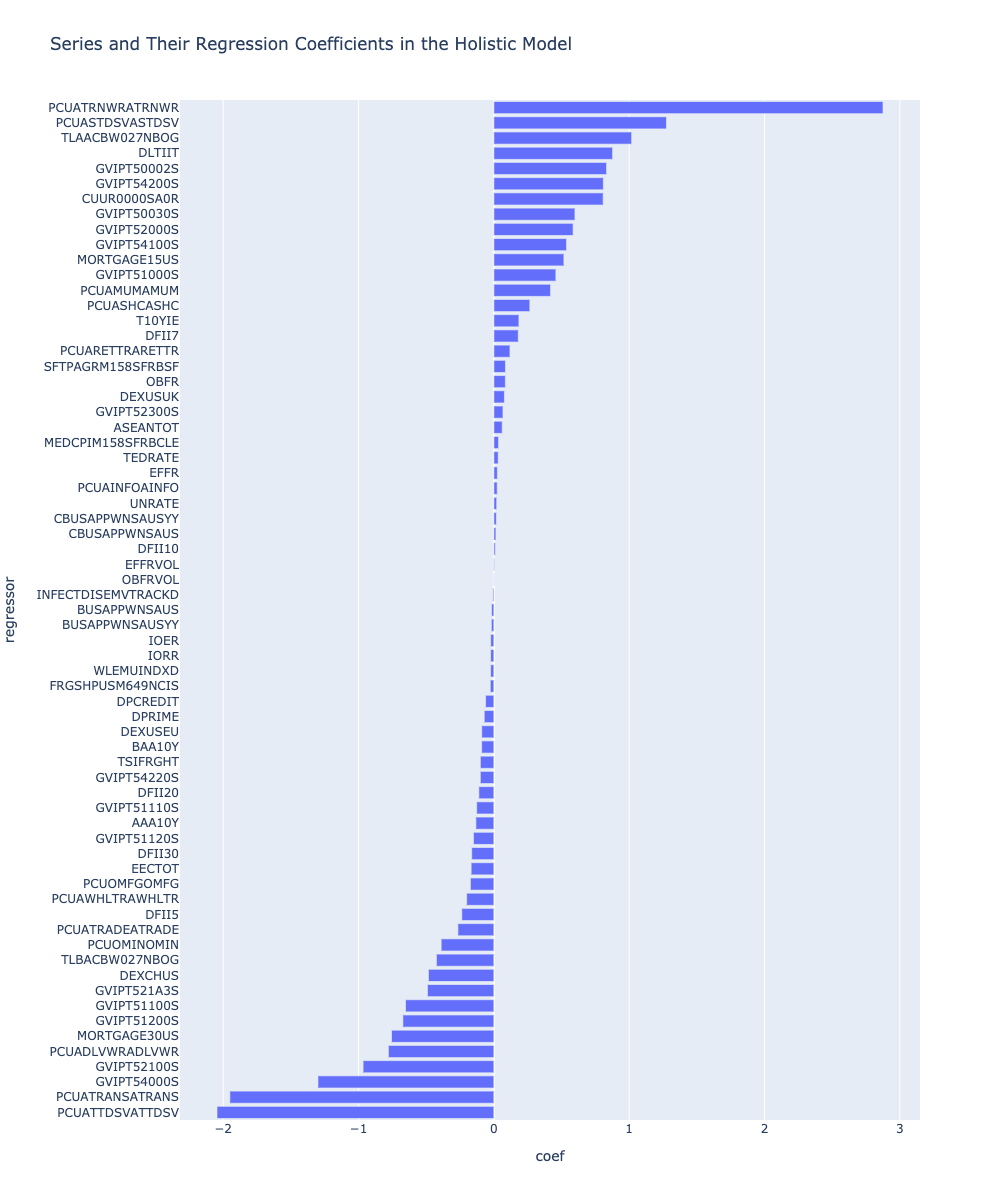

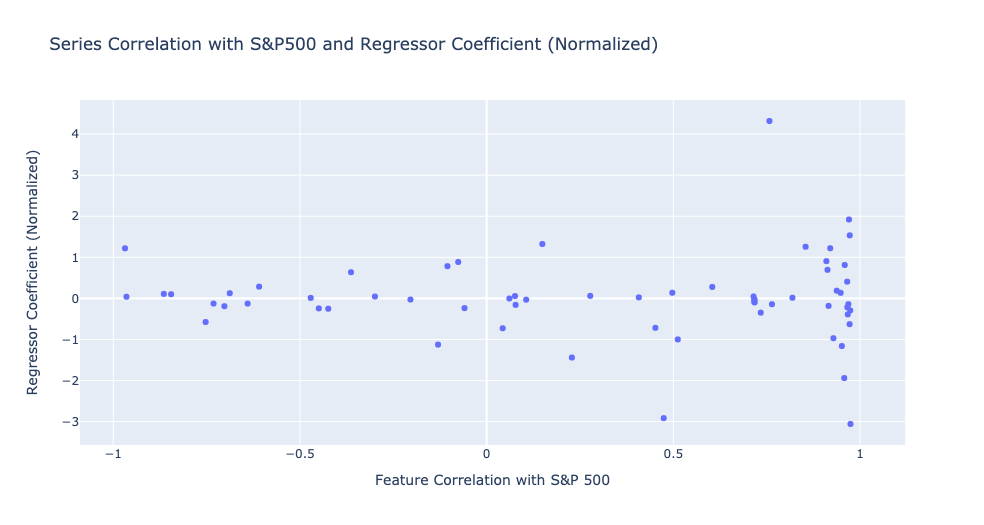

- Most important factors: Transportation and Warehousing Industries, Services Sector, Nonindustrial supply production
- Least important factors: Bank funding rate, Business Application Volume, Unemployment rate (surprising)
- Idea: only the factors which contribute most to the model should be included
- Execution: sort by absolute magnitude of coefficients, and test models

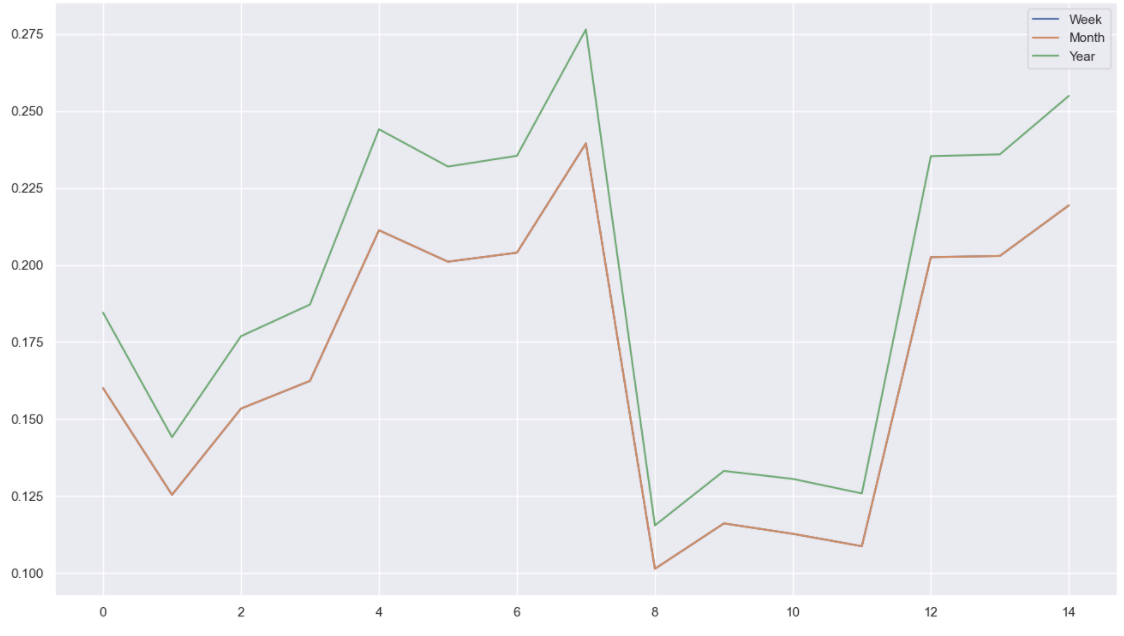

### Conclusion: Top 9 factors are the best, + Infectious Diseases (for 2020)

# Hyperparameters

``` Python
param_grid = {  
	'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
	'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
```

**Cross-validation with 1yr, 1mo, and 1wk training data**
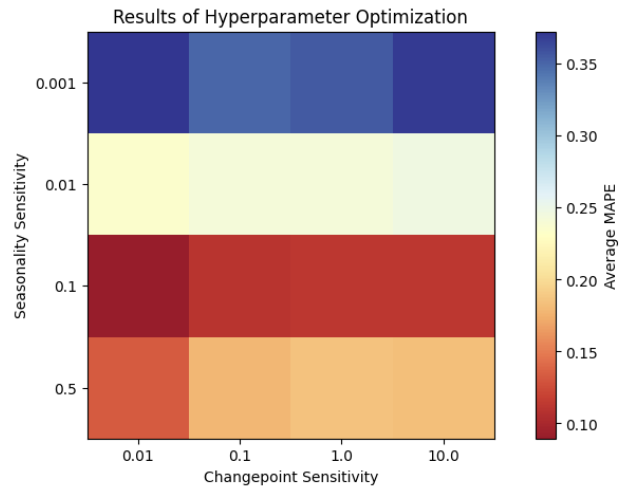

### Conclusion: lowering seasonality sensitivity to 0.1 + changepoint sensitivity to 0.01 (0.001 for 1wk timeline)


# Final Results:



**Cross-validation MAPE:**
- 1 year: 0.095412
- 1 month: 0.086615
- 1 week: 0.086615


# Visualization:
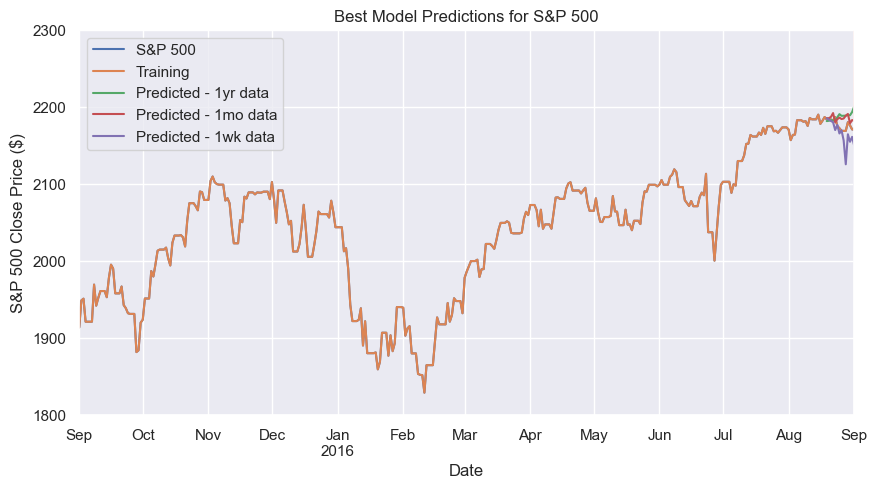

We can see how the lack of data in the 1wk model adversely affects the prediction. It just so happens that there is a sharp drop on the Thursday of our training data, so the model wants to believe a changepoint has occurred and that the market will continue to decline in subsequent weeks. Not unlike a novice investor who has only been in the market for one week!

# Notable Findings

# Unrate is not useful, but infectious disease is useful.
Reasoning: 

- Often times, the target demographic for investing tend to be those with excess capital, therefore it would not make much sense for those who are struggling to find employment to make a marginal impact on the cash flows into the market. People who are often out of work do not have excess capital to expend in investing. 

- Infectious disease causes media panic which drives speculation and poor buying decisions

- Unemployment rate is often an effect of the economic state, infectious disease causes bad economic states (i.e. coronavirus)


# Conclusion

Changepoint prior scale of 0.1 is clearly best, with lower seasonality prior appearing to work better (probably due to the relatively small amounts of data we're training with)
Also, tests show that 8-10 top components, + Infectious Disease, work across the board in almost halving MAPE.
